## Circuit file format:

    N number of qubits

    Gate Qubit/Control [Target]

### Stabilizer formalism

Instead of keeping track of a $2^n$ size array describing the state of the system, we can for a certain class of circuits use $n$ stabilizer operators to describe our system, and so only have to store $n \times 2n$ values. This is possible since we can find $n$ stabilizers that uniquely determine the state of the system (and thus are the generators for the group $S$ that stabilizes the system). Importantly, these generators are a subset of the $n$ qubit Pauli group $G_n$, which is constructed from all possible tensor product combinations of $n$ operators from the single qubit Pauli group $G_1 = \{\pm I, \pm i I, \pm X, \pm i X, \pm Y, \pm i Y, \pm Z, \pm i Z \}$.

An operator $U$ stabilizes $|\psi\rangle$ iff
$$ U |\psi\rangle = |\psi\rangle $$

And so we see that the ground state of a single qubit has the stabilizer $Z$ since

$ Z |0\rangle = |0\rangle $

For a $n$ qubit system $|\psi\rangle = |0\rangle^{\otimes n}$ we have the $n$ stabilizers $Z_1 \equiv Z_1 \otimes I_2 \otimes I_3 \otimes ... \otimes I_n$, $Z_2 \equiv I_1 \otimes Z_2 \otimes I_3 \otimes ... \otimes I_n$, etc...

From now on I will try to refer to the stabilizers we store in our code as the "generators". 

#### Evolving the stabilizers

So we know that we can encode the state by keeping track of $n$ generators, and following the typical procedure of starting our circuit in state $|\psi\rangle = |0\rangle^{\otimes n}$, we know that our initial generators are $n$ operators $Z_i$ working on qubit $i$ respectively. The first question then is how do we evolve these generators as we add gates to the circuit?

Assume we add the gate $U$, then the system is described by the state
$$ |\psi'\rangle = U |\psi\rangle $$
so we must now find the $n$ generators that stabilize $|\psi'\rangle$. Our previous state was stabilised by the $n$ generators $g$, such that $ g |\psi\rangle = |\psi\rangle $, therefore
$$ U |\psi\rangle = U g |\psi\rangle = (U g U^\dagger) U |\psi\rangle $$
and so $U g U^\dagger$ stabilizes the new state $ U |\psi\rangle $.

Take f.ex a Hadamard gate on the $j$'th qubit of an initial $n$ qubit system $|0\rangle^{\otimes n}$, then the generator $g_j = Z_j \rightarrow H Z_j H^\dagger = X_j$, while the other generators are left unchanged. For Hadamard, S, CNOT, X, Y and Z gates, outputs for given input stabilizers can be found in table 10.7 of page 460 in "Quantum computation and information" by Nielsen and Chuang. Of special interest is that these gates map elements of the subset $\{ I, X, Y, Z\}$ to another element of this subset, so that we can ignore the $\pm i$ elements of the Pauli group.

#### Encoding the generators

We only need operators $I_j$, $X_j$, $Y_j$ and $Z_j$ to describe any generator, and need to store $n$ genereators consisting of $n$ single qubit operators. Furthermore, we can express $Y_j=iX_jZ_j$. Thus the check matrix is a good way to encode the generators, ie. we keep track of the existence of $X_j$ and $Z_j$ in qubit number $j$'s operator of the generator $g^{(i)}$. We also have to keep track of the sign of $g^{(i)}$. The check matrix looks like follows:

$$
\begin{pmatrix} p^{(1)} \\ p^{(2)} \\ \vdots \\ p^{(n)} \end{pmatrix} =
\left(
\begin{array}{c|c} \begin{array}{} x_{11} & \dots & x_{1n} \\ x_{21} & \dots & x_{2n} \\ \vdots & \ddots & \vdots \\ x_{n1} & \dots & x_{nn} \end{array} & \begin{array}{} z_{11} & \dots & z_{1n} \\ z_{21} & \dots & z_{2n} \\ \vdots & \ddots & \vdots \\ z_{n1} & \dots & z_{nn} \end{array} \end{array}
\right)
$$

Each row corresponds to a generator. So the single qubit operator on qubit $j$ in generator $g^{(i)}$ is: $I$ if $x_{ij} = z_{ij} = 0$, $X$ if $x_{ij} = 1$ and $z_{ij} = 0$, $Z$ if $x_{ij} = 0$ and $z_{ij} = 1$, $Y$ if $x_{ij} = z_{ij} = 1$. It can be easily seen that the inital matrix for the $|0\rangle^{\otimes n}$ state is $(0|I)$.

#### Measuring a qubit
Measuring the $a$'th qubit corresponds to applying the operator $Z_a$ to our system. There are two possibilities:

- All generators commute with $Z_a$, ie. there is no $X_a$ single qubit operator in any of the generators $g$.
- One or more generators anti-commute with $Z_a$, ie. there is a $X_a$ single qubit operator in one or more of the generators $g$. But if $g^{(q)}$ and $g^{(j)}$ both anti-commute with $Z_a$, then $g^{(q)} g^{(j)}$ commutes with $Z_a$, and we can replace $g^{(j)}$ with $g^{(q)} g^{(j)}$ which is also a generator for the group that stabilizes $|\psi\rangle$.

In the first case $Z_a |\psi\rangle = Z_a g|\psi\rangle = g Z_a |\psi\rangle$, so the generators $g$ stabilize $Z_a |\psi\rangle$ and the system remains unchanged by the measurement. The $a$'th qubit is in a predetermined eigenstate of $Z_a$, we just need to find out if the eigenvalue is $+1$ (ie. $|0\rangle$) or $-1$ (ie. $|1\rangle$).

In the second case it can be shown (see Nielsen and Chaung) that there is a 50% probability of measuring either +1 or -1. Assuming $Z_a$ anti-commutes with $g^{(q)}$, we replace all other generators $g^{(j)}$ that anti-commute with $Z_a$ with $g^{(q)} g^{(j)}$ so that all generators except $g^{(q)}$ now commute with $Z_a$. Since the measurement forces qubit $a$ to either state $|0\rangle$ or $|1\rangle$ we must replace $g^{(q)}$ with $Z_a$ if we measure $+1$ and $-Z_a$ if we measure $-1$, since we know that $Z_a$ or $-Z_a$ now must stabilize the system after the measurement.

## Tableau algorithm

#### The rowsum(h,j) function

This function aims to implement the replacement of generator $g^{(h)}$ with $g^{(h)} g^{(j)}$. 

Consider the single qubit operator in $g^{(h)}$ and $g^{(j)}$ on qubit $k$, which can be: $$I_k = X_k X_k = Z_k Z_k$$ $$X_k$$ $$Y_k = i X_k Z_k$$ $$Z_k$$

We now see how they transform such that $x_{hk} \leftarrow x_{hk} \otimes x_{jk}$ and $z_{hk} \leftarrow z_{hk} \otimes z_{jk}$. Here $\otimes$ denotes the XOR-operation. A few examples are

- $I_k^{(h)} I_k^{(j)}$ s.t $x_{hk}=z_{hk}=x_{jk}=z_{jk} = 0$ thus $x_{hk} \otimes x_{jk} = z_{hk} \otimes z_{jk} = 0$ and so $I_k^{(h)} I_k^{(j)} = I$
- $X_k^{(h)} Z_k^{(j)}$ s.t $x_{hk}=z_{jk} = 1 $ $ x_{jk}=z_{hk} = 0$ thus $x_{hk} \otimes x_{jk} = z_{hk} \otimes z_{jk} = 1$ and so $X_k^{(h)} Z_k^{(j)} = -iY$
- $Y_k^{(h)} X_k^{(j)}$ s.t $x_{hk}=z_{hk}=x_{jk} = 0 $ and $z_{jk} = 0$ thus $x_{hk} \otimes x_{jk} = 0 $ and $ z_{hk} \otimes z_{jk} = 1$ and so $Y_k^{(h)} X_k^{(j)} = -iZ$

One can check that all other combinations also satisfy this relation (in particular it is easy to see that two similar operators will generate $I$).

We must also keep track of the total sign of the new generator. For each single qubit operator multiplication we can get a factor $1 = i^0$ if the two operators are equal or one is $I$. Otherwise we get $i = i^1$ or $-i = i^{-1}$ according to the cyclic rule of the $X$, $Y$, $Z$ operators. We thus see that the factor from one such multiplication is given by:
$$ g(x_a, z_a, x_b, z_b) = \begin{cases}
0 & \text{if } x_a=z_a=0,\\
z_b - x_b  & \text{if } x_a=z_a=1 ,\\
z_b(2x_b - 1)  & \text{if } x_a = 1 \text{ and } z_a = 0,\\
x_b(1 - 2x_b)  & \text{if } x_a = 0 \text{ and } z_a = 1
\end{cases} $$

Summing over the $n$ operator multiplications we get
$$\sum_{k=1}^{n} g(x_{jk}, z_{jk}, x_{hk}, z_{hk})$$
and since we know that our factor will be a real number, this sum must be divisible by 2 or 4, giving a contribution to the total factor of -1 or +1 respectively. Also, the signs of $r_h$ and $r_j$ the generators $g_h$ and $g_j$ must be accounted for. The sign for the new generator is then given by
$$ r_h \leftarrow \frac{ \left( 2r_h + 2r_j + \sum_{k=1}^{n} g(x_{jk}, z_{jk}, x_{hk}, z_{hk}) \right) \mod{4}}{2} $$

In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
def XOR(a,b):
    return int(a != b)

In [3]:
class circuit:
    def __init__(self, filename):
        self.Nqubits = 0
        self.gates = []
        
        with open(filename, 'r') as reader:
            self.Nqubits = int(reader.readline()[0])
            
            for line in reader:
                if line  != '\n':
                    self.gates.append([line.split()[0]] + [int(q) for q in line.split()[1:]])
        
        self.tableau = np.concatenate((np.eye(2*self.Nqubits, dtype='int'), np.zeros((2*self.Nqubits,1), dtype='int')), axis=1)
        self.tableau = np.concatenate((self.tableau, np.zeros((1,2*self.Nqubits+1), dtype='int')), axis=0)
    
    def apply_Hadamard_gate(self, a):
        """
        Applies H-gate to qubit number a
        """
        
        for i in range(2*self.Nqubits):
            # r_i = r_i xor x_ia * z_ia
            self.tableau[i, 2*self.Nqubits] = XOR(self.tableau[i, 2*self.Nqubits], \
                                                 self.tableau[i, a]*self.tableau[i, a+self.Nqubits])
            
            # swap x_ia with z_ia
            self.tableau[i, a], self.tableau[i, a+self.Nqubits] = self.tableau[i, a+self.Nqubits], self.tableau[i, a]
    
    def apply_S_gate(self, a):
        """
        Applies S-gate to qubit number a
        """
        
        for i in range(2*self.Nqubits):
            # r_i = r_i xor x_ia * z_ia
            self.tableau[i, 2*self.Nqubits] = XOR(self.tableau[i, 2*self.Nqubits], \
                                                 self.tableau[i, a]*self.tableau[i, a+self.Nqubits])
            
            # z_ia = x_ia xor z_ia
            self.tableau[i, a+self.Nqubits] = XOR(self.tableau[i, a+self.Nqubits], self.tableau[i, a])
        
        
    def apply_CNOT_gate(self, a, b):
        """
        Applies CX-gate to qubit number a
        """
        
        for i in range(2*self.Nqubits):
            # r_i = r_i xor x_ia * z_ib * (x_ib xor z_ia xor 1)
            self.tableau[i, 2*self.Nqubits] = XOR(self.tableau[i, 2*self.Nqubits], \
                                                 self.tableau[i, a]*self.tableau[i, b+self.Nqubits] \
                                                 * XOR(self.tableau[i, b], XOR(self.tableau[i, a+self.Nqubits], 1)))
            
            # x_ib = x_ib xor x_ia
            self.tableau[i, b] = XOR(self.tableau[i, b], self.tableau[i, a])
            
            # z_ia = z_ia xor z_ib
            self.tableau[i, a+self.Nqubits] = XOR(self.tableau[i, a+self.Nqubits], self.tableau[i, b+self.Nqubits])
    
    def simulate_circuit(self):
        """
        Build the circuit
        """
        for gate in self.gates:
            if gate[0] == 'H':
                self.apply_Hadamard_gate(gate[1])
            elif gate[0] == 'S':
                self.apply_S_gate(gate[1])
            elif gate[0] == 'CX':
                self.apply_CNOT_gate(gate[1], gate[2])
    
    def rowsum(self, h, j):
        """
        Helper function outlined by Aaronson, S. and Gottesman, D.
        """
        
        def g(x1, z1, x2, z2):
            if x1 == 0 and z1 == 0: return 0
            elif x1 == 1 and z1 == 1: return z2-x2
            elif x1 == 1 and z1 == 0: return z2*(2*x2-1)
            elif x1 == 0 and z1 == 1: return x2*(1-2*z2)
                
            
        m = (2*self.tableau[h, 2*self.Nqubits]+2*self.tableau[j, 2*self.Nqubits] \
             + np.sum([g(self.tableau[j, k], self.tableau[j, k+self.Nqubits], self.tableau[h, k], \
                         self.tableau[h, k+self.Nqubits]) for k in range(self.Nqubits)])) % 4
        

        # r_h = m/2
        self.tableau[h, 2*self.Nqubits] = m/2
        
        for k in range(self.Nqubits):
            # x_hk = x_jk xor x_hk
            self.tableau[h, k] = XOR(self.tableau[j, k], self.tableau[h, k])
            
            # z_hk = z_jk xor z_hk
            self.tableau[h, k+self.Nqubits] = XOR(self.tableau[j, k+self.Nqubits], self.tableau[h, k+self.Nqubits])
    
    def measure_qubit(self, a):
        """
        Measures qubit number a
        """
        deterministic = True
        q = 0
        
        # Check if measurement is deterministic or random
        for p in range(self.Nqubits,2*self.Nqubits):
            if self.tableau[p, a] == 1:
                deterministic = False
                q = p
                break
        
        if deterministic:
            # Case of deterministic measurement
            
            for j in range(self.Nqubits):
                if self.tableau[j, a] == 1:
                    self.rowsum(2*self.Nqubits, j + self.Nqubits)
            
            res = self.tableau[2*self.Nqubits, 2*self.Nqubits]
            self.tableau[2*self.Nqubits] = np.zeros(2*self.Nqubits+1, dtype='int')
            
            return res
                
        
        else:
            # Case of random measurement
            
            # The q'th generator g_q was found to anticommute with the measurment operator Z_q,
            # so we transform all other generators g_j!=g_q such that they do not commute with Z_q.
            # This we do by setting g_j=g_j g_q, ie. taking rowsum(j,q). Our new generators generate the
            # same group!
            for j in range(2*self.Nqubits):
                if j == q or self.tableau[j, a] != 1: 
                    continue
                self.rowsum(j,q)
            
            # Set (q-n)'th row equals the q'th row
            self.tableau[q-self.Nqubits] = self.tableau[q]
            
            # Set x_qj = z_qj = 0 for all j
            self.tableau[q] = np.zeros(2*self.Nqubits+1, dtype='int')
            # Set z_qa = 1
            self.tableau[q, a+self.Nqubits] = 1
            
            # Set r_q to be 0 or 1 with equal probability
            self.tableau[q, 2*self.Nqubits] = np.random.randint(0,2)
            
            # Return r_q as the measurement result
            return self.tableau[q, 2*self.Nqubits]
    
    def measure_system(self):
        """
        Measures the wavefunction at the end of the circuit
        """
        wavefunction = np.zeros(self.Nqubits, dtype='int')
        for i in range(self.Nqubits-1, -1, -1):
            wavefunction[i] = self.measure_qubit(i)
        
        
        # By some reason I can only measure from last to first qubit
        #for i in range(self.Nqubits):
        #    wavefunction[i] = self.measure_qubit(i)
        
        return wavefunction
                            

## Testing

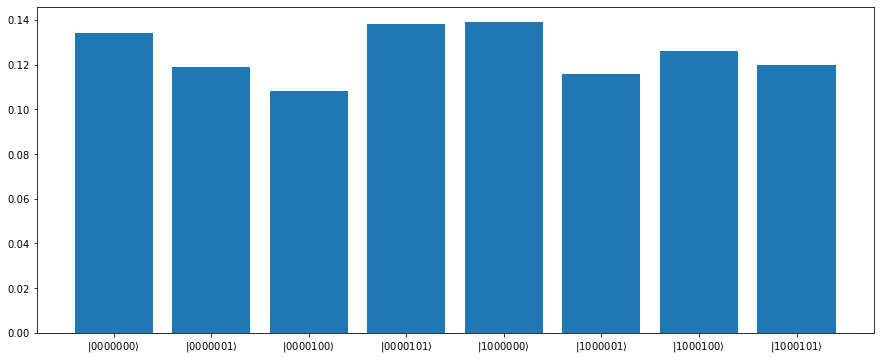

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

fname = 'TestCircuit3.txt'
circ = circuit(fname)
states = [('$|{0:0>' + str(int(circ.Nqubits)) + r'b}\rangle$').format(x) for x in range(2**circ.Nqubits)]
counts = np.zeros(2**circ.Nqubits)



for i in range(1000):
    circ = circuit(fname)
    circ.simulate_circuit()
    
    res = circ.measure_system()
    
    # This may be the wrong way? Could be that it has to be reversed
    counts[np.sum([res[i]*(2**i) for i in range(len(res))])] += 1


mask = np.argwhere(counts==0)
counts = np.delete(counts, mask)
states = np.delete(states, mask)
x = np.arange(len(states))        

plt.figure(figsize=(15, 6))
plt.bar(x, counts/np.sum(counts))
plt.xticks(x, states, fontsize=10)
plt.show()

#### Qiskit benchmark

In [18]:
qc = QuantumCircuit(circ.Nqubits)
for gate in circ.gates:
    if gate[0] == 'H':
        qc.h(gate[1])
    elif gate[0] == 'S':
        qc.s(gate[1])
    elif gate[0] == 'CX':
            qc.cx(gate[1], gate[2])

qc.draw()


┌───┐┌───┐          ┌───┐
q_0: ─────┤ X ├┤ H ├───────■──┤ H ├
          └─┬─┘├───┤       │  └───┘
q_1: ───────┼──┤ X ├───────┼───────
     ┌───┐  │  └─┬─┘┌───┐  │       
q_2: ┤ H ├──■────┼──┤ S ├──┼───────
     ├───┤       │  └───┘  │       
q_3: ┤ S ├───────■─────────┼───────
     ├───┤┌───┐┌───┐┌───┐  │       
q_4: ┤ S ├┤ X ├┤ S ├┤ S ├──┼───────
     └───┘└─┬─┘└───┘└───┘  │       
q_5: ───────┼──────────────┼───────
            │            ┌─┴─┐     
q_6: ───────■────────────┤ X ├─────
                         └───┘

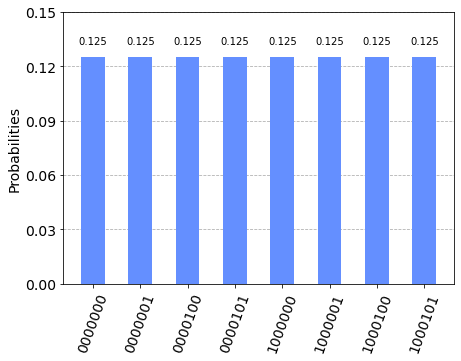

In [19]:
# Let's get the result:
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
result = svsim.run(qobj).result()

final_state = result.get_statevector()
#print(final_state)
plot_histogram(result.get_counts())